<hr style="border: 2px solid coral"></hr>

# MPI_Gather and MPI_Gatherv

<hr style="border: 2px solid coral"></hr>

The functions `MPI_Gather` and `MPI_Gatherv` can be used to "gather" data onto a single node.  This can be used to create an output file from all the data used. 

`MPI_Gather` and  `MPI_Gatherv` are examples of *collective communication* routines.  

We start with a single example illustrating the basic task, using `MPI_Send` and `MPI_Recv`.

* <a href="#gather_v1">Gathering data onto a single rank</a>


A second set of examples illustrates the above tasks using `MPI_Gather`. 


* <a href="#gather_v2">MPI_Gather (version 1)</a>

* <a href="#gather_v3">MPI_Gather (version 2, final)</a>


For grid data, you can look at these two examples.  In this example, we introduce the use of `MPI_Gatherv`. 

* <a href="#gather_grid_v1">MPI_Gather (version 1)</a>

* <a href="#gatherv_v2">MPI_Gatherv (version 2, final)</a>



In [1]:
from matplotlib.pyplot import *
from numpy import *

<a id="gather_v0"></a>

### Example : "Gathering" data from all processors using MPI_Send/MPI_Recv

<hr style="border:2px solid black"></hr>

Gather can be used any time we need to collective "gather" information from all the ranks. 

Suppose we wanted each processor to compute the result of multiplying their rank by $\pi$, and then report the result to rank 0.  A simple code that does this is

In [5]:
%%file gather_01.c

#include <stdio.h>
#include <stdlib.h>

#include <mpi.h>
#include <math.h>


int main(int argc, char** argv)
{
    MPI_Init(&argc, &argv);

    int rank, nprocs;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &nprocs);
    
    double r_pi = rank*M_PI;    
    
    if (rank == 0)
    {
        int tag = 0;
        double *results = (double*) malloc(nprocs*sizeof(double));
        results[0] = r_pi;  // # assign rank 0 entry.
        for(int p = 1; p < nprocs; p++)
        {
            int source = p;            
            MPI_Recv(&results[p],1,MPI_DOUBLE,source,tag,MPI_COMM_WORLD,MPI_STATUS_IGNORE);
        }
        for(int p = 0; p < nprocs; p++)
        {
            printf("Results on rank %d is %f\n",p,results[p]);
        }
        free(results);
    }
    else
    {
        int dest = 0;        
        int tag = 0;
        MPI_Send(&r_pi,1,MPI_DOUBLE,dest,tag,MPI_COMM_WORLD);
    }

    MPI_Finalize();
    return 0;
}

Overwriting gather_01.c


In [7]:
%%bash

rm -rf gather_01.o gather_01

mpicc -o gather_01 gather_01.c 

mpirun -n 4 ./gather_01

Results on rank 0 is 0.000000
Results on rank 1 is 3.141593
Results on rank 2 is 6.283185
Results on rank 3 is 9.424778


<a id="gather_v1"></a>


### Example : "Gathering" data using MPI_Gather (version 1)

<hr style="border:2px solid black"></hr>

Because "gathering" is such a common task, MPI has built in functions which accomplish this with essentially a single command.  Furthermore, the built in command will generally be much more efficiecient, since it is based on a tree-like commmunication structure. 

The gather command has the following syntax. 

    int MPI_Gather (void *sendbuf, int sendcnt, MPI_Datatype sendtype,
                    void *recvbuf, int recvcount, MPI_Datatype recvtype,
                    int root, MPI_Comm comm);


where

* **sendbuf** is the data on an individual processor to be sent

* **sendcnt** is the number of elements to be sent

* **sentype** is the MPI Data type, e.g. `MPI_DOUBLE`, `MPI_INT`, etc

* **recvbuf** is the buffer on the `root` node that should receive all the entries. 

* **recvcount** Number of elements that *each proc* sends. 

* **recvtype** MPI Data type of the buffer to be received. 

* **root** The node that "gathers" the data

* **comm** The MPI communicator.


You can links to all MPI routines [here](https://hpc-tutorials.llnl.gov/mpi/appendix_a/).

In [8]:
%%file gather_02.c

#include <stdio.h>
#include <stdlib.h>

#include <mpi.h>
#include <math.h>


int main(int argc, char** argv)
{
    MPI_Init(&argc, &argv);

    int rank, nprocs;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &nprocs);
    
    double r_pi = rank*M_PI;
    
    int root = 0;
    double * recv_buf;
    recv_buf = (double*) malloc(nprocs*sizeof(double));        
            
    int recv_count = 1;
    
    MPI_Gather(&r_pi,1,MPI_DOUBLE,recv_buf,recv_count,MPI_DOUBLE,root,MPI_COMM_WORLD);
    
    if (rank == root)
    {
        for(int p = 0; p < nprocs; p++)
            printf("Result from rank %d is %g\n",p,recv_buf[p]);        
    }        
    free(recv_buf);
    
    MPI_Finalize();
    return 0;
}

Overwriting gather_02.c


In [9]:
%%bash

rm -rf gather_02

mpicc -o gather_02 gather_02.c 

mpirun -n 8 ./gather_02

Result from rank 0 is 0
Result from rank 1 is 3.14159
Result from rank 2 is 6.28319
Result from rank 3 is 9.42478
Result from rank 4 is 12.5664
Result from rank 5 is 15.708
Result from rank 6 is 18.8496
Result from rank 7 is 21.9911


There is a bug in the above code.   How can we fix it? 

<a id="gather_v2"></a>


### Example : "Gathering" using MPI_Gather (version 2, final)

<hr style="border:2px solid black"></hr>

In the above, only rank 0 actually needs to allocate memory for the receive buffer.  Below, we selectively allocate and deallocate memory only on the root node. 

In [10]:
%%file gather_03.c

#include <stdio.h>
#include <stdlib.h>

#include <mpi.h>
#include <math.h>


int main(int argc, char** argv)
{
    MPI_Init(&argc, &argv);

    int rank, nprocs;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &nprocs);
    
    double r_pi = rank*M_PI;
    
    int root = 0;
    double * recv_buf;
    
    if (rank == root)
        recv_buf = (double*) malloc(nprocs*sizeof(double));        
    else
        recv_buf = NULL;
            
    int recv_count = 1;    
    MPI_Gather(&r_pi,1,MPI_DOUBLE,recv_buf,recv_count,MPI_DOUBLE,root,MPI_COMM_WORLD);
    
    if (rank == root)
    {
        for(int p = 0; p < nprocs; p++)
            printf("Result from rank %d is %12.4f\n",p,recv_buf[p]);        
        free(recv_buf);
    }        
    
    MPI_Finalize();
    return 0;
}

Writing gather_03.c


In [12]:
%%bash

rm -rf gather_03

mpicc -o gather_03 gather_03.c 

mpirun -n 8 ./gather_03

Result from rank 0 is       0.0000
Result from rank 1 is       3.1416
Result from rank 2 is       6.2832
Result from rank 3 is       9.4248
Result from rank 4 is      12.5664
Result from rank 5 is      15.7080
Result from rank 6 is      18.8496
Result from rank 7 is      21.9911


<hr style="border:2px solid coral"></hr>

## Using Gather with grid data

<hr style="border:2px solid coral"></hr>

We can use gather to collect solution data from a grid solution onto a single processor.  This is useful for output, for example. 

<a id="gather_grid_v1"></a>


### Example : Writing out grid data using MPI_Gather (version 1)

<hr style="border:2px solid black"></hr>


In [13]:
%%file gather_04.c

#include <stdio.h>
#include <stdlib.h>

#include <mpi.h>
#include <math.h>

double* allocate_1d(int n, int m)
{
    double *mem = (double*) malloc((n + 2*m)*sizeof(double));
    return &mem[m];
}

void free_1d(double **x, int m)
{
    free(&(*x)[-m]);
    *x = NULL;
}


void set_values(int n, double a, double b, double *q)
{
    double pi = M_PI;
    double dx = (b-a)/n;
    for(int i = 0; i < n; i++)
    {
        double x = a +  i*dx;
        q[i] = cos(x);        
    }    
}

int main(int argc, char** argv)
{
    MPI_Init(&argc, &argv);

    int rank, nprocs;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &nprocs);

    int N = 1 << 5;    // # 2^10

    double a = 0;
    double b = 2*M_PI;

    int N_local = N/nprocs;

    double dw = (b-a)/nprocs;
    double a_local = a + rank*dw;
    double b_local = a_local + dw;
    
    /* # Initialize data */
    double *q_local = allocate_1d(N_local+1,0);

    set_values(N_local,a_local, b_local, q_local);
    
    double *q = allocate_1d((N+1),0);

    int root = 0;
    MPI_Gather(q_local,N_local,MPI_DOUBLE,q,N_local,MPI_DOUBLE,root,MPI_COMM_WORLD);        
    
    /* Write out meta-data */
    if (rank == root)
    {
        FILE* fout = fopen("gather_04.out","w");
        fwrite(&N,1,sizeof(int),fout);
        fwrite(&a,1,sizeof(double),fout);
        fwrite(&b,1,sizeof(double),fout);

        fwrite(q,N+1,sizeof(double),fout);
        free(q);
        fclose(fout);        
    }

    MPI_Finalize();
    
    return 0;
}


Writing gather_04.c


In [14]:
%%bash

rm -rf gather_04.o gather_04

mpicc -o gather_04 gather_04.c

mpirun -n 4 ./gather_04

In [15]:
# Open file for reading; use binary mode
fout = open("gather_04.out","rb")

# Read meta data
dt = dtype([('N',int32),('a',float64),('b',float64)])
N,a,b = fromfile(fout,dtype=dt, count=1)[0]

# Print meta data from dictionary
print(f"N = {N:d}")
print(f"(a,b) = ({a:.8f},{b:.8f})")

# Read solution data using "N" read above
q = fromfile(fout,dtype=float64,count=N+1)

fout.close()

with printoptions(formatter={'float' : "{:.8f}".format}):
    print("")
    print("q = ",end="")
    print(q)

N = 32
(a,b) = (0.00000000,6.28318531)

q = [1.00000000 0.98078528 0.92387953 0.83146961 0.70710678 0.55557023
 0.38268343 0.19509032 0.00000000 -0.19509032 -0.38268343 -0.55557023
 -0.70710678 -0.83146961 -0.92387953 -0.98078528 -1.00000000 -0.98078528
 -0.92387953 -0.83146961 -0.70710678 -0.55557023 -0.38268343 -0.19509032
 -0.00000000 0.19509032 0.38268343 0.55557023 0.70710678 0.83146961
 0.92387953 0.98078528 0.00000000]


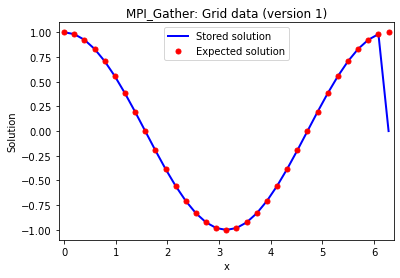

In [16]:
fig = figure(1)
clf()

x = linspace(a,b,N+1)

err = abs(q-cos(x)).max()

plot(x,q,'b',lw=2,label="Stored solution")
plot(x,cos(x),'ro',ms=5,label="Expected solution")

xlabel('x')
ylabel('Solution')
xlim([a-0.1,b+0.1]);

title("MPI_Gather: Grid data (version 1)")

legend();


<a id="gatherv_v2"></a>

### Example : Writing out grid data using MPI_Gatherv (version 2, final)

<hr style="border:2px solid black"></hr>

From the above, it seems that we need  to be able to send a variable number of elements depending on the processor rank.   We can do this using a second MPI function `MPI_Gatherv`.   

`MPI_Gatherv` gathers a variable number of elements into specified locations in a receive buffer.   

Rather than received a constant number of elements, into equally spaced locations, `MPI_Gatherv` takes a variable number of counts and "displacements", where the displacement is the location from the start of the receive buffer. 

     int MPI_Gatherv ( void *sendbuf, int sendcnt, MPI_Datatype sendtype,
                       void *recvbuf, int *recvcnts, int *displs,
                       MPI_Datatype recvtype, int root, MPI_Comm comm )
                       
* **recvcnts** A buffer containing the number of entries to gather  from each processor. 

* **displs** The location in the receive buffer to store the entries. 

Each of the two buffers above should be of length equal to the number of processors. 

You can read more about `MPI_Gatherv` [here](https://hpc-tutorials.llnl.gov/mpi/MPI_appendix/MPI_Gatherv.txt).

##### Comment

`MPI_Gatherv` allows for overlap of data.   The same location in the gather array may have values written from more than one processor. 

In [17]:
%%file gather_05.c

#include <stdio.h>
#include <stdlib.h>

#include <mpi.h>
#include <math.h>

double* allocate_1d(int n, int m)
{
    double *mem = (double*) malloc((n + 2*m)*sizeof(double));
    return &mem[m];
}

void free_1d(double **x, int m)
{
    free(&(*x)[-m]);
    *x = NULL;
}


void set_values(int n, double a, double b, double *q)
{
    double pi = M_PI;
    double dx = (b-a)/n;
    for(int i = 0; i < n+1; i++)
    {
        double x = a +  i*dx;
        q[i] = cos(x);        
    }    
}

int main(int argc, char** argv)
{
    MPI_Init(&argc, &argv);

    int rank, nprocs;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &nprocs);

    int N = 1 << 5;    // # 2^10

    double a = 0;
    double b = 2*M_PI;

    int N_local = N/nprocs;

    double dw = (b-a)/nprocs;
    double a_local = a + rank*dw;
    double b_local = a_local + dw;
    
    /* # Initialize data */
    double *q_local = allocate_1d(N_local+1,0);

    set_values(N_local,a_local, b_local, q_local);
    
    int root = 0;
    int *recv_counts, *displs;
    double *q;
    if (rank == root)
    {
        q = allocate_1d(N+1,0);
    
        recv_counts = (int*) malloc(nprocs*sizeof(int));
        displs = (int*) malloc(nprocs*sizeof(int));
    
        for(int p = 0; p < nprocs; p++)
        {
            recv_counts[p] = N_local+1;
            displs[p] = p*N_local;
        }
    }

    MPI_Gatherv(q_local,N_local+1,MPI_DOUBLE,q,recv_counts,displs,MPI_DOUBLE,root,MPI_COMM_WORLD);        
    
    if (rank == root)
    {
        FILE* fout = fopen("gather_05.out","w");
        fwrite(&N,1,sizeof(int),fout);
        fwrite(&a,1,sizeof(double),fout);
        fwrite(&b,1,sizeof(double),fout);

        fwrite(q,N+1,sizeof(double),fout);
        fclose(fout);        
        free_1d(&q,0);
    }

    MPI_Finalize();
    
    return 0;
}


Writing gather_05.c


In [19]:
%%bash

rm -rf gather_05.o gather_05

mpicc -o gather_05 gather_05.c 

mpirun -n 4 ./gather_05

In [20]:
# Open file for reading; use binary mode
fout = open("gather_05.out","rb")

# Read meta data
dt = dtype([('N',int32),('a',float64),('b',float64)])
N,a,b = fromfile(fout,dtype=dt, count=1)[0]

# Read solution data using "N" read above
q = fromfile(fout,dtype=float64,count=N+1)

fout.close()

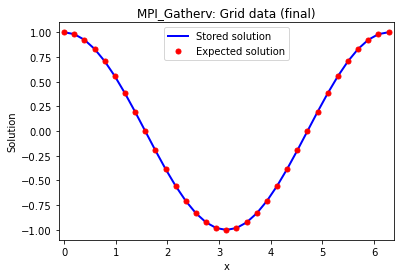

In [21]:
fig = figure(2)
clf()

x = linspace(a,b,N+1)

err = abs(q-cos(x)).max()

plot(x,q,'b',lw=2,label="Stored solution")
plot(x,cos(x),'ro',ms=5,label="Expected solution")

xlabel('x')
ylabel('Solution')
xlim([a-0.1,b+0.1]);

title("MPI_Gatherv: Grid data (final)")

legend();
